In [1]:
!pip install yfinance

In [2]:
!pip install ecos
!pip install --upgrade setuptools wheel
!pip install --upgrade pip
!pip install PyPortfolioOpt

In [3]:
!pip install plotly

In [4]:
!pip install seaborn

In [49]:
# Import necessary libraries
#Grab Data 
import yfinance as yf

#Usual Suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

 #Use PyPortfolioOpt for Calculations 
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import black_litterman
from pypfopt import risk_models, BlackLittermanModel
from pypfopt import DiscreteAllocation

In [17]:
#Create a Portfolio
symbols = [
    'AAPL',
    'MSFT',
    'META',
    'AMZN',
    'GOOGL',
    'TSLA',
    'XOM',
    'UNH',
    'JNJ',
    'V',
    'MD',
    'ABBV',
    'KO',
    'DIS',
    'T',
    'UPS',
    'LMT',
    'CAT',
    'F',
    'MAR',
    'O',
    'HSV'
]

In [18]:
#get the stock data
portfolio = yf.download(symbols, start='2018-01-01', end='2024-01-01')['Adj Close']

portfolio.head()

[*********************100%***********************]  22 of 22 completed

1 Failed download:
['HSV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2024-01-01)')


Ticker,AAPL,ABBV,AMZN,CAT,DIS,F,GOOGL,HSV,JNJ,KO,...,MD,META,MSFT,O,T,TSLA,UNH,UPS,V,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02 00:00:00+00:00,40.568924,72.923515,59.450500,134.323608,107.875175,8.995990,53.527958,NaN,115.682419,36.817024,...,54.740002,180.875397,79.792931,40.122528,17.223801,21.368668,200.148483,98.553383,109.311729,61.637554
2018-01-03 00:00:00+00:00,40.561855,74.064674,60.209999,134.528931,108.338326,9.067047,54.441196,NaN,116.787476,36.736179,...,54.560001,184.115646,80.164268,40.016235,16.826057,21.150000,202.248093,100.736900,110.399986,62.848118
2018-01-04 00:00:00+00:00,40.750271,73.642281,60.479500,136.376480,108.290092,9.223372,54.652668,NaN,116.779182,37.253597,...,54.610001,183.776672,80.869820,39.151711,16.982473,20.974667,203.125916,101.390358,110.810455,62.935097
2018-01-05 00:00:00+00:00,41.214226,74.924240,61.457001,138.531937,107.701492,9.379702,55.377377,NaN,117.743011,37.245510,...,54.500000,186.289108,81.872444,39.123375,17.045040,21.105333,206.999268,101.701141,113.464256,62.884350
2018-01-08 00:00:00+00:00,41.061153,73.723785,62.343498,142.013199,106.157661,9.344174,55.572891,NaN,117.892555,37.188911,...,53.480000,187.714813,81.955994,39.172989,17.094198,22.427334,203.406448,102.936348,113.922462,63.167057


In [8]:
#SP500 ETF Benchmark
market_prices = yf.download('SPY', start='2018-01-01', end='2023-01-01')['Adj Close']
market_prices.head()

#We take the SPY which is an ETF of the S&P 500 as our benchmark

[*********************100%***********************]  1 of 1 completed


Date
2018-01-02    240.801529
2018-01-03    242.324585
2018-01-04    243.345978
2018-01-05    244.967667
2018-01-08    245.415634
Name: Adj Close, dtype: float64

In [9]:
#Grab the Market Capitalization for each stock in portfolio
mcaps = {}
for t in symbols:
    stock = yf.Ticker(t)
    # Check if 'marketCap' exists in stock.info
    if "marketCap" in stock.info:
        mcaps[t] = stock.info["marketCap"]
    # else:
    #     mcaps[t] = None  # or handle it as needed
mcaps

{'AAPL': 3429740838912,
 'MSFT': 3106378874880,
 'META': 1452167266304,
 'AMZN': 1911354818560,
 'GOOGL': 2040932335616,
 'TSLA': 790737256448,
 'XOM': 544557203456,
 'UNH': 544105562112,
 'JNJ': 387854499840,
 'V': 539066728448,
 'MD': 1029530944,
 'ABBV': 345763184640,
 'KO': 303479521280,
 'DIS': 169842704384,
 'T': 158605721600,
 'UPS': 112434421760,
 'LMT': 144676143104,
 'CAT': 190361239552,
 'F': 41462255616,
 'MAR': 69750136832,
 'O': 53966381056}

### Step 2: Getting Priors

In [10]:
#Calculate Sigma and Delta to get implied market returns (weights)
#Ledoit-Wolf is a particular form of shrinkage, where the shrinkage coefficient is computed using o?
S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()
S
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

/Users/vimalvatsa/.pyenv/versions/3.10.10/lib/python3.10/site-packages/pypfopt/expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna(how="all")


1.9618072380252582

<Axes: xlabel='Ticker', ylabel='Ticker'>

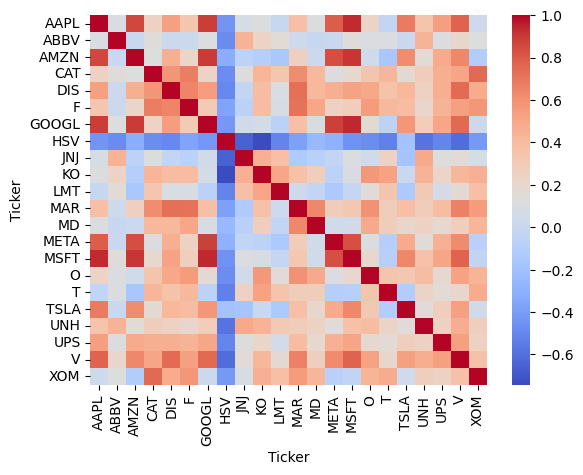

In [11]:
#Visualize the Covariant Correlation
#Heat map for the coorlation matrix between the stocks and shrinkage
sns.heatmap(S.corr(), cmap='coolwarm')

In [12]:

print(mcaps)

{'AAPL': 3429740838912, 'MSFT': 3106378874880, 'META': 1452167266304, 'AMZN': 1911354818560, 'GOOGL': 2040932335616, 'TSLA': 790737256448, 'XOM': 544557203456, 'UNH': 544105562112, 'JNJ': 387854499840, 'V': 539066728448, 'MD': 1029530944, 'ABBV': 345763184640, 'KO': 303479521280, 'DIS': 169842704384, 'T': 158605721600, 'UPS': 112434421760, 'LMT': 144676143104, 'CAT': 190361239552, 'F': 41462255616, 'MAR': 69750136832, 'O': 53966381056}


In [13]:
print(S.columns)

Index(['AAPL', 'ABBV', 'AMZN', 'CAT', 'DIS', 'F', 'GOOGL', 'HSV', 'JNJ', 'KO',
       'LMT', 'MAR', 'MD', 'META', 'MSFT', 'O', 'T', 'TSLA', 'UNH', 'UPS', 'V',
       'XOM'],
      dtype='object', name='Ticker')


In [20]:
# Align Tickers: Ensure mcaps and S have the same tickers by finding the intersection of their keys/columns.
# Filter mcaps and S: Update mcaps and S to only include the common tickers.
common_tickers = list(set(mcaps.keys()).intersection(set(S.columns)))
mcaps = {k: mcaps[k] for k in common_tickers}
S = S.loc[common_tickers, common_tickers]


In [21]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

Ticker
LMT      0.070067
O        0.084005
XOM      0.085530
MD       0.096683
CAT      0.099561
TSLA     0.200498
MSFT     0.154101
GOOGL    0.151815
AMZN     0.158852
ABBV     0.075755
UNH      0.095498
AAPL     0.157353
F        0.114105
META     0.176885
KO       0.068055
JNJ      0.064642
V        0.120216
MAR      0.112915
T        0.069130
UPS      0.097170
DIS      0.111392
dtype: float64

<Axes: ylabel='Ticker'>

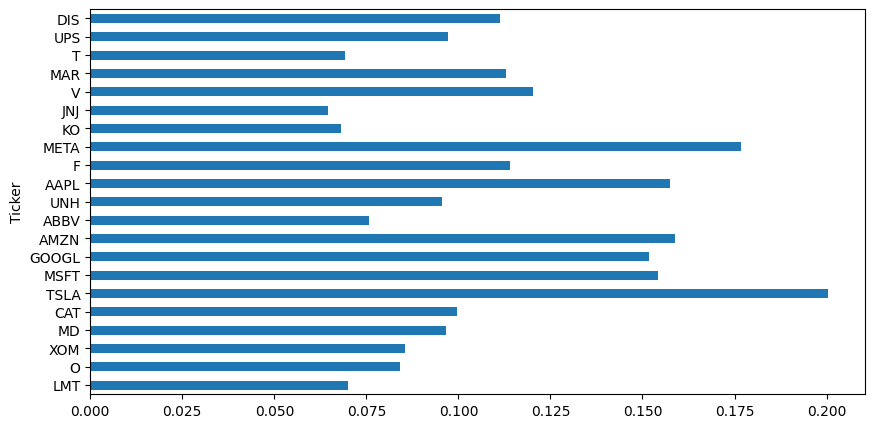

In [23]:
#Plottiing the market prior - how much are we going to be compensated per the risk that we are going to take when allocating a stock
market_prior.plot.barh(figsize=(10,5))

### Step 3: Integrating Views

In [25]:
#You don't have to provide views on all the assets
#You can provide views on a subset of the assets
viewdict = {
    'AAPL': 0.10,
    'MSFT':0.30,
    'META': 0.05,
    'AMZN': 0.30,
    'XOM':0.02,
    'UNH':0.01,
    'JNJ':0.15,
    'V':0.09,
    'HD':0.16,
    'ABBV':0.07,
    'KO':0.01,
    'DIS':-0.23,
    'T':0.16,
    'UPS':0.10,
    'LMT':-0.09,
    'CAT':0.30,
    'F':0.16,
    'MAR':-0.08,
    'O':0.30,
    'HSV':-0.26,
}

# Filter viewdict to only include tickers present in S
viewdict = {k: v for k, v in viewdict.items() if k in S.columns}

b1 = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

### Creating Confidences
    we can calculate the uncertainity matrix directly by specifying 1 standard deviation intervals, i.e, bounds which we think will contain the true 68% of the time. This may be easier than coming up with somewhat arbitary confidences. 

In [34]:
intervals = [
    (0, 0.25), (0.1, 0.4), (-0.1, 0.15), (-0.05, 0.1), (0.15, 0.25),
    (-0.1, 0), (0.1, 0.2), (0.08, 0.12), (0, 0.3), (0, 0.25),
    (0.1, 0.9), (0.08, 0.12), (0.1, 0.4), (-0.1, 0.15), (-0.05, 0.1),
    (0.15, 0.25), (-0.1, 0), (0.08, 0.12), (0.1, 0.9), (0, 0.3)
]
# Adjust the number of intervals to match the number of views
intervals = intervals[:len(viewdict)]

In [35]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb) / 2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances) #place the variances on the diagonal of the matrix

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.0225, 0.015625, 0.16000000000000003, 0.00039999999999999986, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986]


### Step 4: Calculate Posterior Estimate Returns

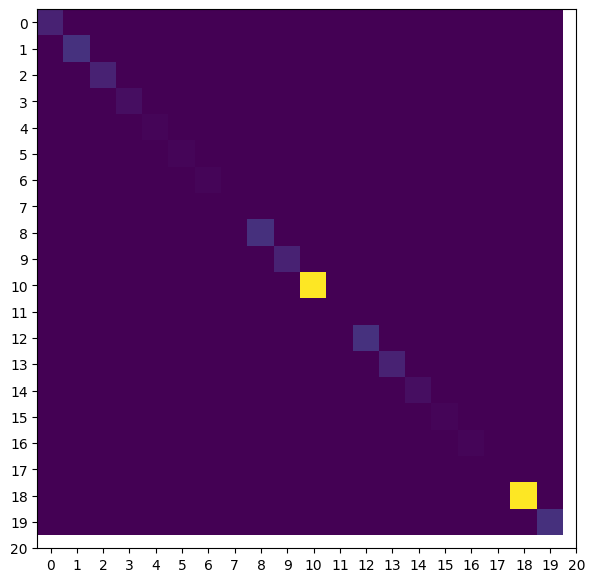

In [31]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(omega)

#We want to show all ticks...
ax.set_xticks(np.arange(len(S.columns)))
ax.set_yticks(np.arange(len(S.columns)))

In [36]:
#We are using the shortcut to automatically compute market-implied prior, S - Shrinkage Covariance Matrix, and delta - Risk Aversion
b1 = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_averison=delta, absolute_views=viewdict, omega=omega)

In [38]:
#Posterior estimate of returns 
ret_b1 = b1.bl_returns()
ret_b1

Ticker
LMT      0.068815
O        0.269088
XOM      0.061234
MD       0.104887
CAT      0.145005
TSLA     0.202742
MSFT     0.155840
GOOGL    0.134866
AMZN     0.176479
ABBV     0.081729
UNH      0.068691
AAPL     0.143459
F        0.154692
META     0.141175
KO       0.096359
JNJ      0.098561
V        0.098586
MAR      0.004793
T        0.149417
UPS      0.105786
DIS      0.113064
dtype: float64

In [39]:
#passing those returns to the efficient data frame
rets_df = pd.DataFrame([market_prior, ret_b1, pd.Series(viewdict)], 
                       index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
LMT,0.070067,0.068815,-0.09
O,0.084005,0.269088,0.30
XOM,0.085530,0.061234,0.02
MD,0.096683,0.104887,NaN
CAT,0.099561,0.145005,0.30
TSLA,0.200498,0.202742,NaN
MSFT,0.154101,0.155840,0.30
GOOGL,0.151815,0.134866,NaN
AMZN,0.158852,0.176479,0.30
ABBV,0.075755,0.081729,0.07


<Axes: >

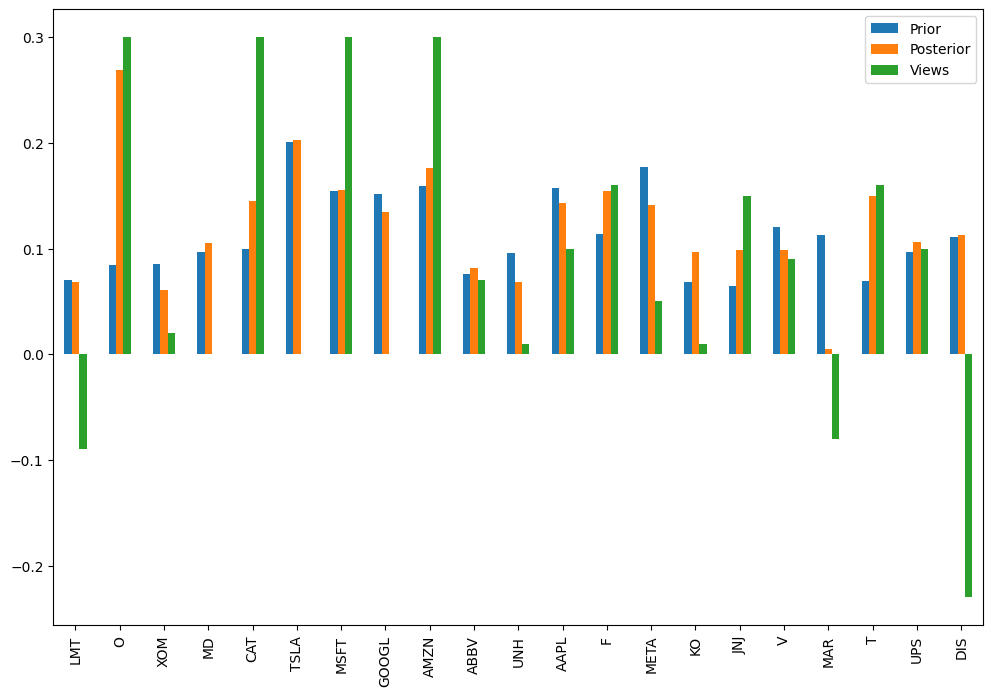

In [41]:
rets_df.plot.bar(figsize=(12,8))

<Axes: xlabel='Ticker'>

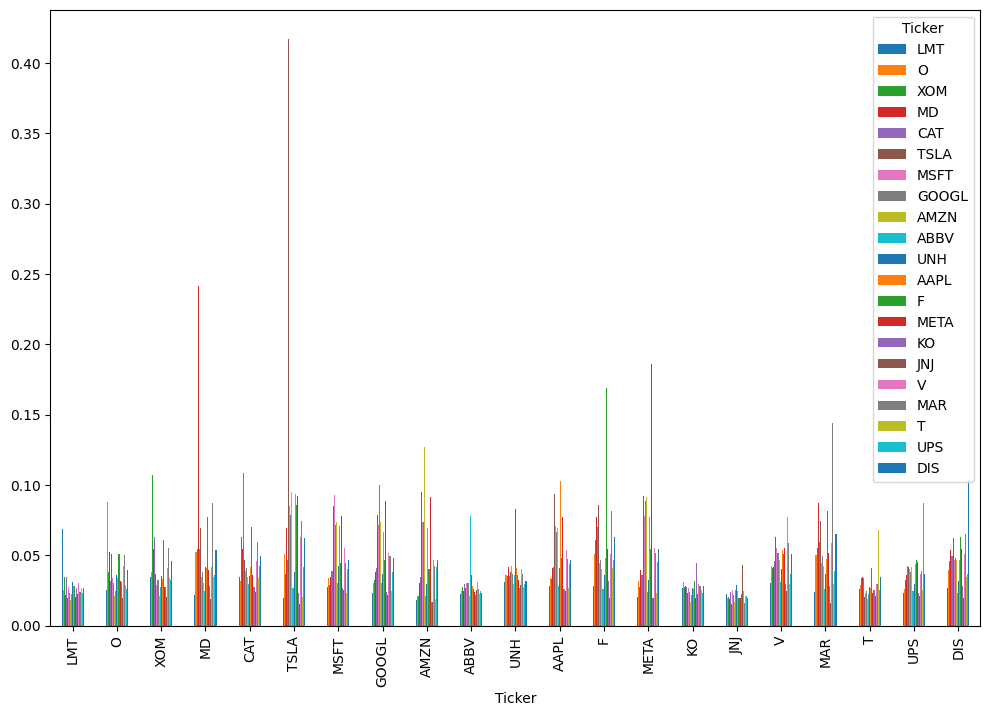

In [55]:
S_b1 = b1.bl_cov()
#plotting covariances
S_b1.plot.bar(figsize=(12,8))

### Step 5: Portfolio Allocation

In [56]:
ef = EfficientFrontier(ret_b1, S_b1)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/Users/vimalvatsa/.pyenv/versions/3.10.10/lib/python3.10/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('LMT', 0.01626),
             ('O', 0.1717),
             ('XOM', 0.0),
             ('MD', 0.02433),
             ('CAT', 0.06424),
             ('TSLA', 0.07241),
             ('MSFT', 0.06593),
             ('GOOGL', 0.04868),
             ('AMZN', 0.08372),
             ('ABBV', 0.02617),
             ('UNH', 0.007),
             ('AAPL', 0.05425),
             ('F', 0.05911),
             ('META', 0.04635),
             ('KO', 0.03931),
             ('JNJ', 0.04582),
             ('V', 0.02226),
             ('MAR', 0.0),
             ('T', 0.08129),
             ('UPS', 0.03713),
             ('DIS', 0.03406)])

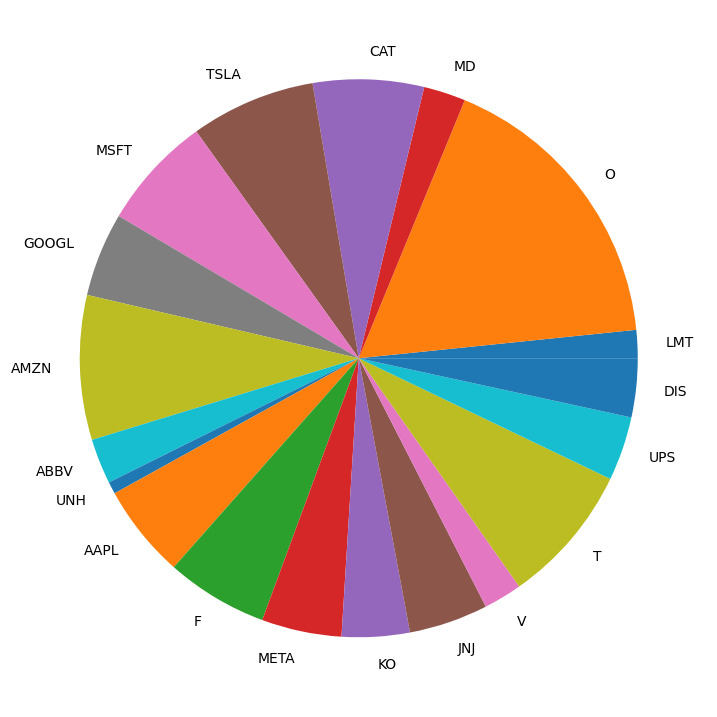

In [58]:
#pie chart of the portfolio allocation
pd.Series(weights).plot.pie(figsize=(9,10));

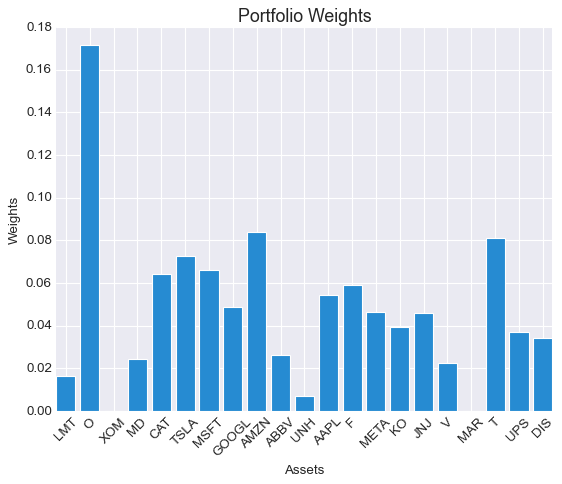

Expected annual return: 16.2%
Annual volatility: 21.5%
Sharpe Ratio: 0.66


(0.16199466829408482, 0.2153303309747613, 0.6594271585024774)

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

ef = EfficientFrontier(ret_b1, S_b1)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
# Extract keys and values
assets = list(weights.keys())
values = list(weights.values())
# Plot the weights
plt.bar(assets, values)
plt.xlabel('Assets')
plt.ylabel('Weights')
plt.title('Portfolio Weights')
plt.xticks(rotation=45)
plt.show()


ef.portfolio_performance(verbose= True, risk_free_rate = 0.009)

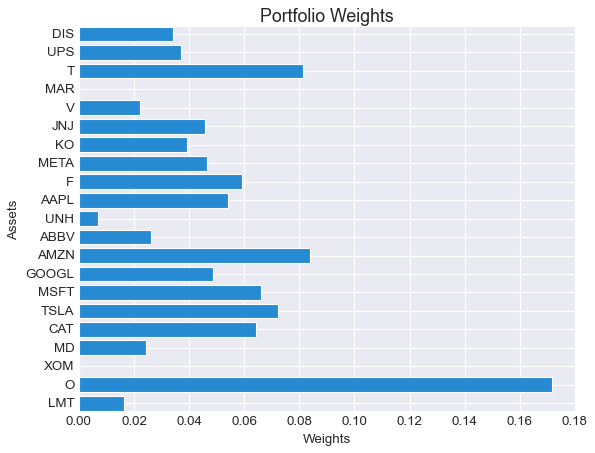

Expected annual return: 16.2%
Annual volatility: 21.5%
Sharpe Ratio: 0.66


(0.16199466829408482, 0.2153303309747613, 0.6594271585024774)

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

ef = EfficientFrontier(ret_b1, S_b1)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
# Extract keys and values
assets = list(weights.keys())
values = list(weights.values())

# Plot the weights as a horizontal bar chart
plt.barh(assets, values)
plt.xlabel('Weights')
plt.ylabel('Assets')
plt.title('Portfolio Weights')
plt.show()
ef.portfolio_performance(verbose= True, risk_free_rate = 0.009)